In [1]:
!pip install allantools

  Created wheel for allantools: filename=AllanTools-2019.9-py2.py3-none-any.whl size=40677 sha256=845da003de1362fd72522d4480c3a269b858e22bdd77ad157457c8017b0fa039
  Stored in directory: /root/.cache/pip/wheels/4f/2d/a2/2818a818596ce0cbb0a89732710d77224ec6f46fafc4122eb1
Successfully built allantools


In [2]:
import allantools
from scipy.signal import welch
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from allan_variance import overlapping_allan_deviation, plot_allan_deviation

In [3]:
def welch_PSD(data, title, ref={"power":0.0, "label":"$\\nabla=0$"}, verbose=True):

    """Wrapper for `scipy.signal.welch`. This method immediately plots the resulting
        power spectral density on a log log scale.

    Args:
    data (numpy array) - Time series that the power spectral density is being
                            calculated for.
    ref (dict) - Parameters for plotting a power law on top of the PSD.
                    "power" - The exponent of a power law.
                    "label" - The plot label. Usually indicating slope of reference.
    verbose (bool) - Flag for showing the reference line on the plot. 
                        If `False`, no reference dict is needed and no reference is plotted.
    """

    freqs, psd = welch(data)

    plt.loglog(freqs, psd, label="PSD")
    if verbose:
        plt.loglog(freqs[1:], np.power(freqs[1:], ref["power"]), label=ref["label"])

    plt.legend(loc="lower left")
    plt.title(f"{title}")

    plt.show()
    plt.close()
    return 

In [4]:
def get_time_series_statistics(data):

    """Calculate basic summary statistics about `data`

    Args:
    data (numpy array) - Time series to calculate basic statistics for.

    Returns:
    (pandas.DataFrame) - Row vector of basic statistics for `data`.

    """

    return pd.DataFrame(data=data, columns=["Data"]).describe().transpose()

In [5]:
def overlay_statistics_on_time_series(data, title, color="pink"):

    """Plot `data` as a time series along with indicators for mean and std

    Args:
    data (numpy array) - The time series to plot.
    title (str) - Title of the plot.
    color (str) - Color of the plot. Defaults to "pink".
    """

    stats = get_time_series_statistics(data)
    plt.plot(data, label="Data", color=color, alpha=0.3)

    xmax = len(data)
    plt.hlines(stats["mean"], xmin=0, xmax=xmax, label="$\mu$", color='k')
    plt.hlines(stats["mean"]+stats["std"], xmin=0, xmax=xmax, label="$+\sigma$", linestyles="dashed", color='g')
    plt.hlines(stats["mean"]-stats["std"], xmin=0, xmax=xmax, label="$-\sigma$", linestyles="dashed", color='g')
    
    plt.legend(loc="lower left")
    plt.title(f"{title}")

    plt.show()
    plt.close()
    return 

# Building up the simulation

After defining 3 important functions, we can start to build up the simulated example. We start by defining the length of our measurement simulation (via the number of points) and generating the noise series.

The functions above help to examine the generated signals. For example, the PSD is used to verify that the white noise series has equal power across all frequencies (as it is defined). Computing summary statistics for a time series is handled by a single function.

In [6]:
#number of samples
num_points = 10_000

The sampling rate for each sequence is assumed to be $f_{sampling}=1.0 Hz$

In [7]:
white_noise = allantools.noise.white(num_points=num_points)
pink_noise = allantools.noise.pink(num_points=num_points)

In [8]:
w_stats = get_time_series_statistics(white_noise)
w_stats

,count,mean,std,min,25%,50%,75%,max
Data,10000.0,-0.002477,0.709017,-2.727054,-0.481354,-0.00408,0.477351,2.820184


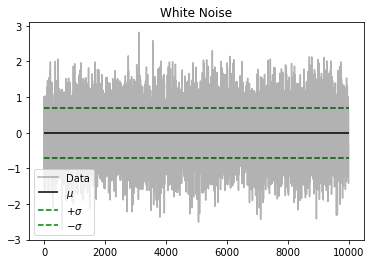

In [9]:
overlay_statistics_on_time_series(white_noise, "White Noise", color='k')

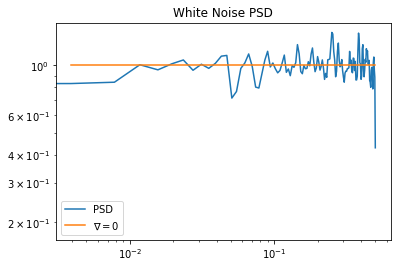

In [10]:
welch_PSD(white_noise, "White Noise PSD")

In [11]:
p_stats = get_time_series_statistics(pink_noise)
p_stats

,count,mean,std,min,25%,50%,75%,max
Data,10000.0,-13.268297,2.84602,-22.94956,-15.207737,-13.306587,-11.344693,-3.694706


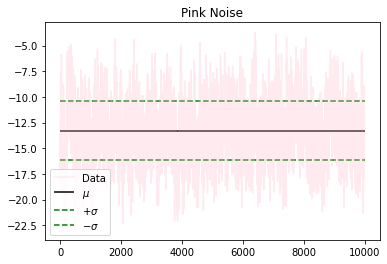

In [12]:
overlay_statistics_on_time_series(pink_noise, "Pink Noise")

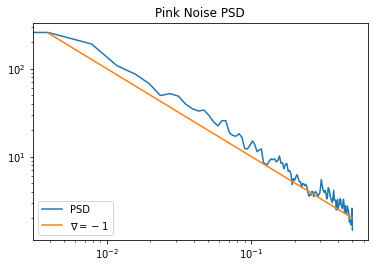

In [13]:
pink_reference = {"power":-1.0, "label":"$\\nabla=-1$"}
welch_PSD(pink_noise, "Pink Noise PSD", ref=pink_reference)

# Scale down the pink noise series and then view its statistics and PSD

I wondered, could scaling down the values of a noise series change its color? I guessed that, no, the scaling the values would not. But in order to test this question, we generate a pink noise sequence, scale it using the scaler function, and view the PSD before + after scaling.

I think viewing the PSD is the correct tool, here, because different colors of noise are *classified* by the PSD roll off.

In [14]:
def scaler(data, target, scale_factor):

    """Scale the values of a time series to fit the target range.

    Args:
    data (numpy array) - The time series with data that needs to be scaled.
    target (numpy array) - The time series with desired min/max range to scale values.
    scale_factor (float) - Adjustable value to change the desired range.
                            Larger values of `scale_factor` makes `data` interfere with 
                            `target` to a greater degree.

    Return:
    (numpy array) - A scaled version of `data`.

    """

    data_stats = get_time_series_statistics(data)
    target_stats = get_time_series_statistics(target)
    
    rmin, rmax = (data_stats["min"].item(), data_stats["max"].item())
    tmin, tmax = (scale_factor*target_stats["min"].item(), scale_factor*target_stats["max"].item())

    return ((data-rmin)/(rmax-rmin))*(tmax-tmin) + tmin

In [15]:
scaled_pink = scaler(pink_noise, white_noise, 0.025)

In [16]:
get_time_series_statistics(scaled_pink)

,count,mean,std,min,25%,50%,75%,max
Data,10000.0,0.001552,0.020498,-0.068176,-0.012417,0.001276,0.015406,0.070505


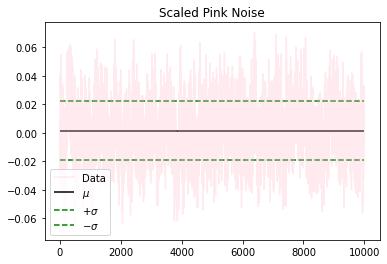

In [17]:
overlay_statistics_on_time_series(scaled_pink, title="Scaled Pink Noise")

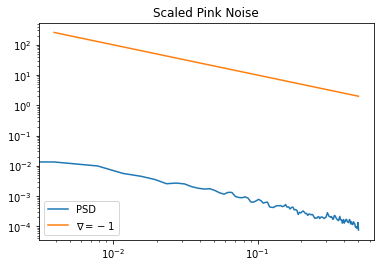

In [18]:
welch_PSD(scaled_pink, "Scaled Pink Noise", ref=pink_reference)

# Combine Pink and White Noise

In [19]:
combined = white_noise + scaled_pink

In [20]:
get_time_series_statistics(combined)

,count,mean,std,min,25%,50%,75%,max
Data,10000.0,-0.000926,0.709342,-2.705791,-0.480407,-0.000839,0.477465,2.846188


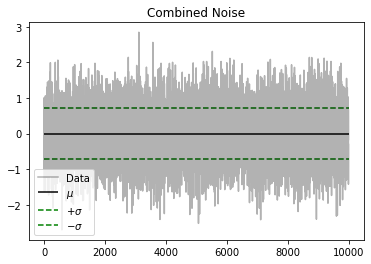

In [21]:
overlay_statistics_on_time_series(combined, "Combined Noise", color='k')

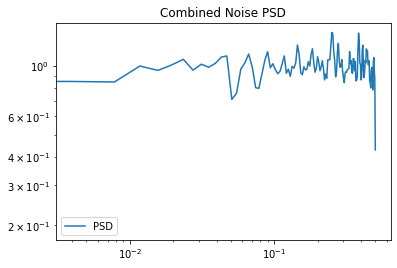

In [22]:
welch_PSD(combined, "Combined Noise PSD", verbose=False)

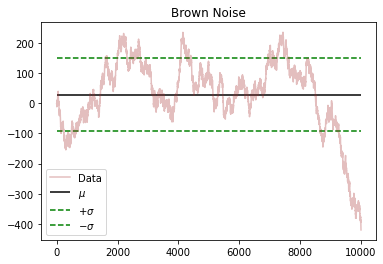

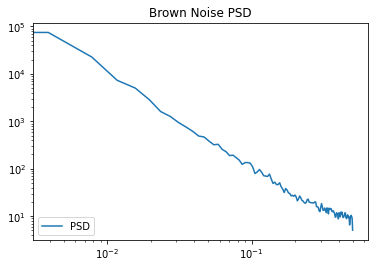

In [23]:
brown_noise = allantools.noise.brown(num_points=num_points)
overlay_statistics_on_time_series(brown_noise, "Brown Noise", color="brown")
b_stats = get_time_series_statistics(brown_noise)
welch_PSD(brown_noise, "Brown Noise PSD", verbose=False)

In [24]:
scaled_brown = scaler(brown_noise, white_noise, 0.03)

In [25]:
combined += scaled_brown

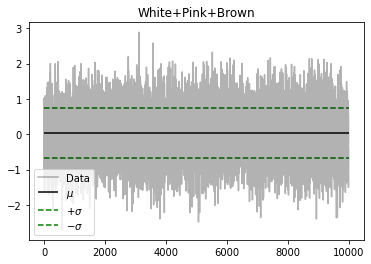

In [26]:
overlay_statistics_on_time_series(combined, "White+Pink+Brown", color='k')

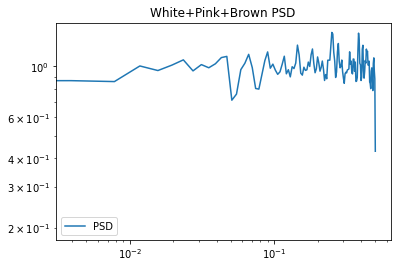

In [27]:
welch_PSD(combined, "White+Pink+Brown PSD", verbose=False)

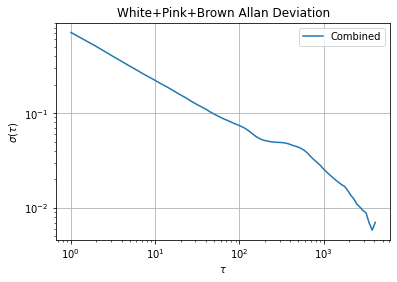

In [28]:
taus, oadev = overlapping_allan_deviation(combined, 1.0)
plot_allan_deviation(taus, oadev, "Combined", "White+Pink+Brown Allan Deviation")

# Define Pipeline for Full Analysis

From the above, we can get the Allan deviation of a combined noise signals. Now, we can wrap those steps in a function so we can do the process multiple times with a single line of code.

We explicitly separate generating the signals and running them through the pipeline because that was the only way the signals would be randomly initialized each time we run the pipeline.


In [29]:
def generate_noise_colors(Fs):

    """Generate 1 hour of white noise, pink noise, and brown noise at specified 
        sampling rate

    Args:
    Fs (int) - Sampling rate in Hz.

    Returns:
    (tuple) - White noise sequence, pink noise sequence, brown noise sequence.
                Each sequence is a numpy array.

    """

    num_points = 3600*Fs

    white = allantools.noise.white(num_points=num_points)
    pink = allantools.noise.pink(num_points=num_points)
    brown = allantools.noise.brown(num_points=num_points)

    return (white, pink, brown)

In [30]:
def pipeline(Fs, pscale, bscale):

    """Wrapper for generating noise with different colors, scaling the noise, 
        and creating (Time Series, PSD, Allan Deviation) plots, all at once.
    
    Args:
    Fs (int) - Sampling rate in Hz.
    pscale (float) - `scale_factor` for Pink Noise.
    bscale (float) - `scale_factor` for Brown Noise.

    """

    title = "Combined Pink {}, Brown {}".format(pscale, bscale)

    white_noise, pink_noise, brown_noise = generate_noise_colors(Fs=Fs)

    scaled_pink = scaler(pink_noise, white_noise, pscale)
    scaled_brown = scaler(brown_noise, white_noise, bscale)

    combined = white_noise + scaled_pink + scaled_brown

    combined_stats = get_time_series_statistics(combined)
    print(combined_stats)

    overlay_statistics_on_time_series(combined, title=title, color='k')

    welch_PSD(combined, title=title+" PSD", verbose=False)

    taus, oadev = overlapping_allan_deviation(combined, Fs=Fs)
    plot_allan_deviation(taus, oadev, "Combined", title=title+" Allan Deviation")

    return 

## Only White Noise

Notice the PSD is essentially uniform, as we would expect with a white noise series.

The Allan deviation also rolls off at $\nabla=-1/2$ as expected.

         count     mean       std  ...       50%       75%       max
Data  360000.0 -0.00051  0.707999  ... -0.000897  0.477437  3.137319

[1 rows x 8 columns]


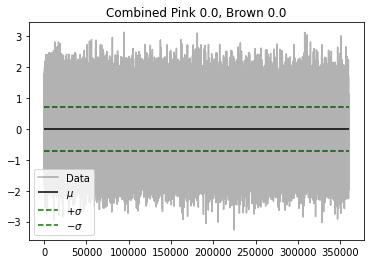

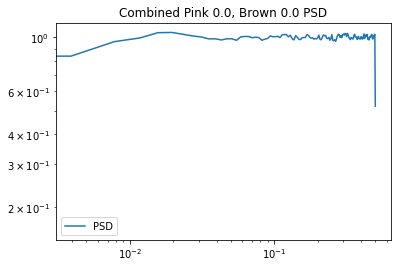

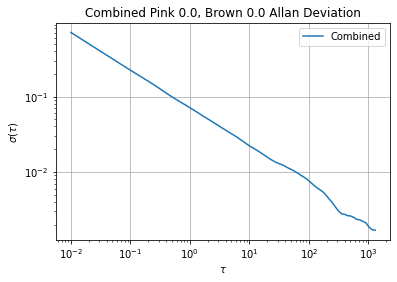

In [31]:
pipeline(100, 0.0, 0.0)

## White Noise + Red Noise 

Here we are not scaling the red noise at all. So in the time series plot, we can see the signal looks like a white noise signal that has brownian motion.

In the range 0Hz to ~10^{-2}Hz, the PSD is rolling off slightly, before evening out to uniform. We know that the PSD of a red noise sequence will roll off as $\frac{1}{f_{s}^{2}}$ and in our simulation, we set $f_{s}=1$. So, it makes sense for there to be some rolloff in the PSD.

Finally, the Allan deviation shows significant ramp up after $\tau=1$. Ramping up is the effect of the added red noise.

As for the downturn seen at $\tau=10^{2.5}$, I think that is an artifact of the randomness used to generate the sequences. We can see in the time series view that there is a sinusoidal-like shape for the gyroscope. The Allan deviation "responds" with a downturn.

*When this notebook is run sequentially, the time series views can change drastically between runs. The overall concepts should be the same, but specifics (like the downturn mentioned above) may not appear on every run.*

         count    mean       std  ...       50%       75%      max
Data  360000.0 -0.1017  1.459623  ...  0.037453  0.923087  5.29021

[1 rows x 8 columns]


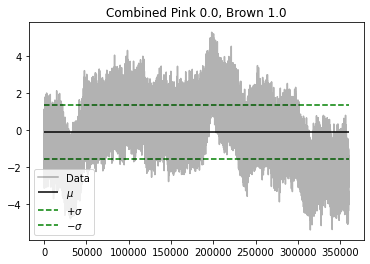

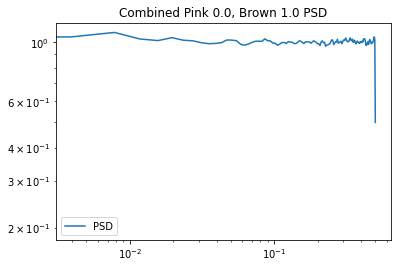

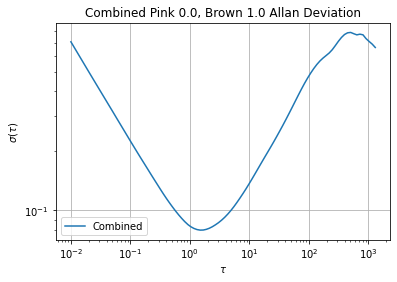

In [32]:
pipeline(100, 0.0, 1.0)

## White Noise + Pink Noise

Here, we add pink noise to the white noise series. We do not do any scaling of the added noise. As a result, the PSD has a slower roll off than the red noise series. 

*I think this observation may be better explained if I change the sampling frequencies since $\frac{1}{f_{s}^{2}}$==$\frac{1}{f_{s}}$ for $f_{s}=1$*

The resulting Allan deviation is similar to what we observed when we were only simulating the addition of pink noise.

         count      mean       std  ...       50%       75%       max
Data  360000.0  0.122316  1.008373  ...  0.123471  0.801724  4.670452

[1 rows x 8 columns]


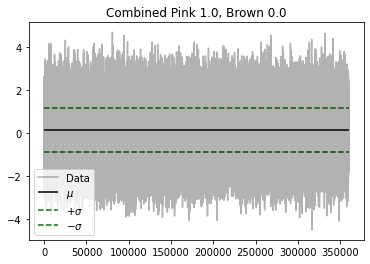

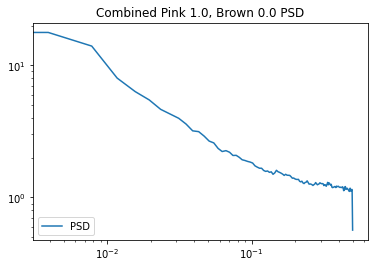

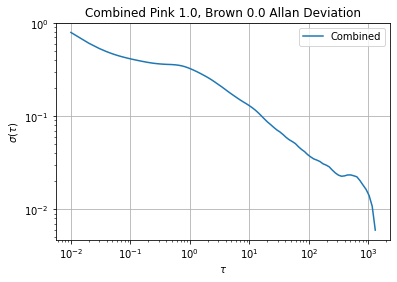

In [33]:
pipeline(100, 1.0, 0.0)

## Combined White Noise + Pink Noise + Red Noise

After tuning the scaling, I found that `pscale=0.03` and `bscale=0.04` tends to give a "good" Allan deviation. As we'll see later, these values do not gurantee that the Allan deviation has any particular shape.

However, I think it's a start for being able to classify + quantify error coefficients when we start doing this analysis in the reverse order (coefficents from an ADEV).

         count      mean       std  ...       50%       75%       max
Data  360000.0  0.040517  0.711351  ...  0.040741  0.520146  3.522333

[1 rows x 8 columns]


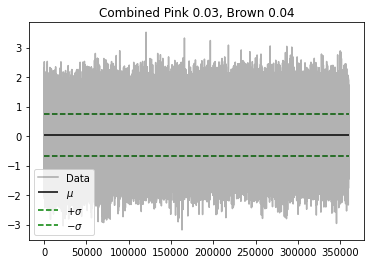

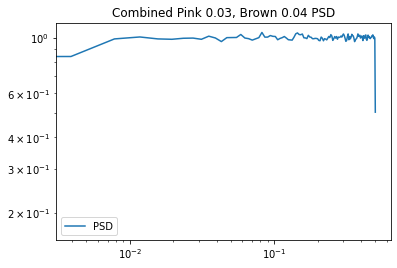

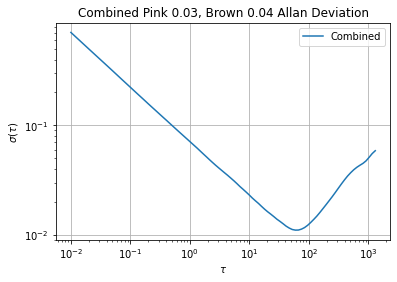

In [34]:
pipeline(100, 0.03, 0.04)

## Combined Signal with Different `bscale`

In this cell, we bring the `bscale` down from the previous example. So, the amplitude of the brown noise sequence is being squished between 10% of the min/max of the white noise series.

The resulting Allan deviations are comparable. However, we note that the ramp up is introduced later than before (from $\tau=10^{2} s$ to $\tau=10^{2.5} s$

So, it might be interesting to "grid search" different `bscale` values to see if we can execute control over these plot characteristics. Again, this is all in service of trying to reverse engineer error coefficients from an existing Allan deviation.

For example, we might try to draw an Allan deviation that approximates the ingested data. In solving that problem, being able to perform horizontal/vertical shifts would be useful.

         count      mean       std  ...      50%       75%       max
Data  360000.0  0.009813  0.708419  ...  0.00997  0.488182  3.574511

[1 rows x 8 columns]


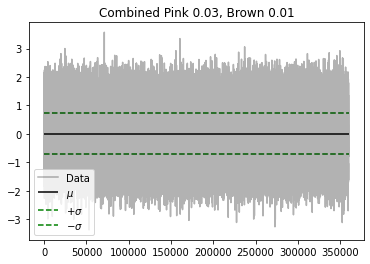

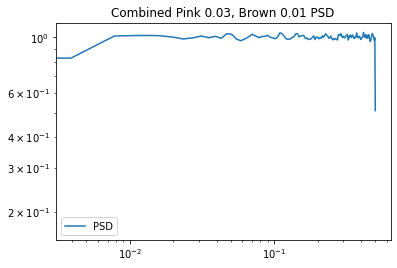

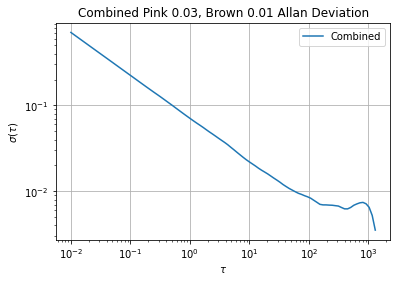

In [35]:
pipeline(100, 0.03, 0.01)

Below, we further reduce the `bscale` and observe the results.

From this cell, we might ask what happens if we increase the maximum number of overlaps allowed in our Allan deviation calculation.

Right now we are capped at the default 100, so $\tau$ will not exceed ~$10^{3}$ s for the number of signal points generated.

         count      mean       std  ...       50%       75%       max
Data  360000.0 -0.001218  0.707121  ... -0.002495  0.476966  3.430363

[1 rows x 8 columns]


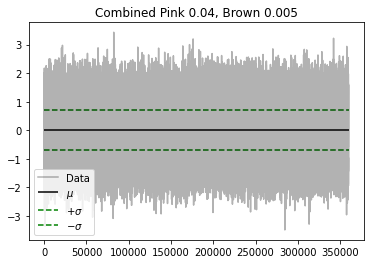

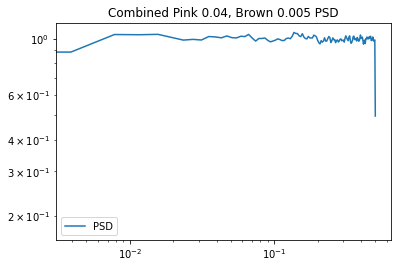

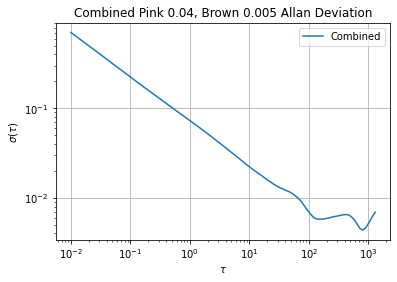

In [36]:
pipeline(100, 0.04, 0.005)

# A number of randomly initiated noise sequences analyzed by Allan deviation

The noise sequences are randomly initialized in this simulation. As we might have noticed, sometimes to get a "good" Allan deviation, we have to run the cell multiple times (equivalent to re-initializing).

If we overlay many runs, we can see this effect in a single plot.

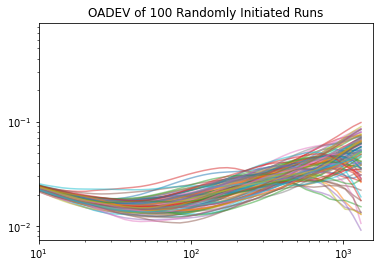

CPU times: user 2min 15s, sys: 1.88 s, total: 2min 17s
Wall time: 2min 17s


In [37]:
%%time
runs = 100

for _ in range(runs):

    Fs = 100
    pscale = 0.03
    bscale = 0.04

    white_noise, pink_noise, brown_noise = generate_noise_colors(Fs=Fs)

    scaled_pink = scaler(pink_noise, white_noise, pscale)
    scaled_brown = scaler(brown_noise, white_noise, bscale)

    combined = white_noise + scaled_pink + scaled_brown

    taus, oadev = overlapping_allan_deviation(combined, Fs=Fs)

    plt.loglog(taus, oadev, alpha=0.5)
    plt.title("OADEV of {} Randomly Initiated Runs".format(runs))
    plt.xlim(10, 10**3.2)

plt.show()
plt.close()

*Note that only $\tau \geq 10$s is plotted to get a better look at the differences in end behavior.*

# How many times does a randomly initiated run perturb the system?

This is the same simulation as above with the addition of counting the number of times a pertubation is introduced to the system.

A pertubation is classified as the presence of local extrema that occur after a certain $\tau$.

The size of the noise sequences means that Allan deviation first minimizes almost always near $\tau= 10^{2} s$. So, we look for pertubations after $\tau = 10^2 s$.

In [38]:
from scipy.signal import argrelextrema

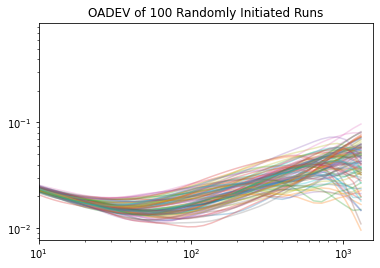

COUNT 64


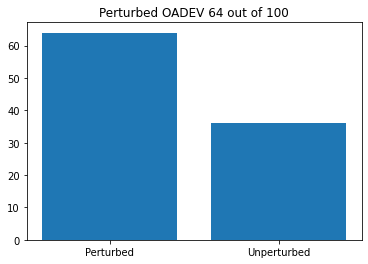

CPU times: user 2min 17s, sys: 1.63 s, total: 2min 18s
Wall time: 2min 19s


In [39]:
%%time
runs = 100
count = 0
for _ in range(runs):

    Fs = 100
    pscale = 0.03
    bscale = 0.04

    white_noise, pink_noise, brown_noise = generate_noise_colors(Fs=Fs)

    scaled_pink = scaler(pink_noise, white_noise, pscale)
    scaled_brown = scaler(brown_noise, white_noise, bscale)

    combined = white_noise + scaled_pink + scaled_brown

    taus, oadev = overlapping_allan_deviation(combined, Fs=Fs)

    rel_max = argrelextrema(oadev, np.greater)
    rel_min = argrelextrema(oadev, np.less)

    ## CHORE:  There is a more elegant way to write this expression
    if True in np.asarray([taus[i]>10**2 for i in rel_max]).flatten() or True in np.asarray([taus[i]>10**2 for i in rel_min]).flatten():
        count += 1

    plt.loglog(taus, oadev, alpha=0.3)
    plt.title("OADEV of {} Randomly Initiated Runs".format(runs))
    plt.xlim(10, 10**3.2)

plt.show()
plt.close()

print(f"COUNT {count}")

plt.bar(["Perturbed", "Unperturbed"], [count, runs-count])
plt.title(f"Perturbed OADEV {count} out of {runs}")
plt.show()

In these simulated stability experiments, the noise sequences interfere to produce a pertubation more often than not.

I wonder if adjusting the scaling of the underlying sequences has an effect on the presence of pertubations.